Missing nodes detected: {'NOAM WASSERMAN', 'MADOFF: THE MONSTER OF WALL STREET', 'YOUTUBE CHANNEL', 'SOCIAL MEDIA NETWORKS', 'PRESS RELEASE', 'CRYPTON', 'HELLO KITTY', 'JORDAN BELFORT', 'PRODUCT-MARKET FIT STAGE', 'OAKLAND ATHLETICS', 'HOLOGRAM', 'GORDON MOORE', 'LOCKDOWNS', 'STOCKBROKER', 'RAY KROC', 'CUSTOMER BEHAVIOUR', 'PROBLEM-SOLUTION FIT STAGE', 'CRYPTOCURRENCY', 'AFTERPAY', 'CHRIS GARDNER', 'BLUE APRON', 'CANALYS', 'ROBERT NOYCE', 'EY', 'PORTFOLIO', 'LIVE CONCERTS', 'GORDON GEKKO', 'CHARACTER DESIGN', 'I SOLUTION', 'PRICE WAR', 'MANAGED SERVICES PROVIDERS', 'HANGOVER CURE', 'PONZI SCHEME', 'BLOCKCHAIN', 'ALGORITHM', 'YAMAHA', 'PANDEMIC', 'BRAND AMBASSADOR', 'MEDIA TARGETS', 'ZOOM', 'IT ENVIRONMENT', 'ASSETS', 'MCAFEE', 'HARVARD BUSINESS', 'AD TECH COMPANY', 'CONSULTING SERVICES', 'ROY ASH', 'VISIONARY', 'MONEYBALL', 'DIGITAL VOICE BANK', 'JESSICA ALBA', 'WALL STREET', 'D2C BUSINESS', 'INTEL', 'SANRIO', 'THE PURSUIT OF HAPPYNESS', 'OUTSIDE ADVISOR', 'END-TO-END COOKING EXPERIENC

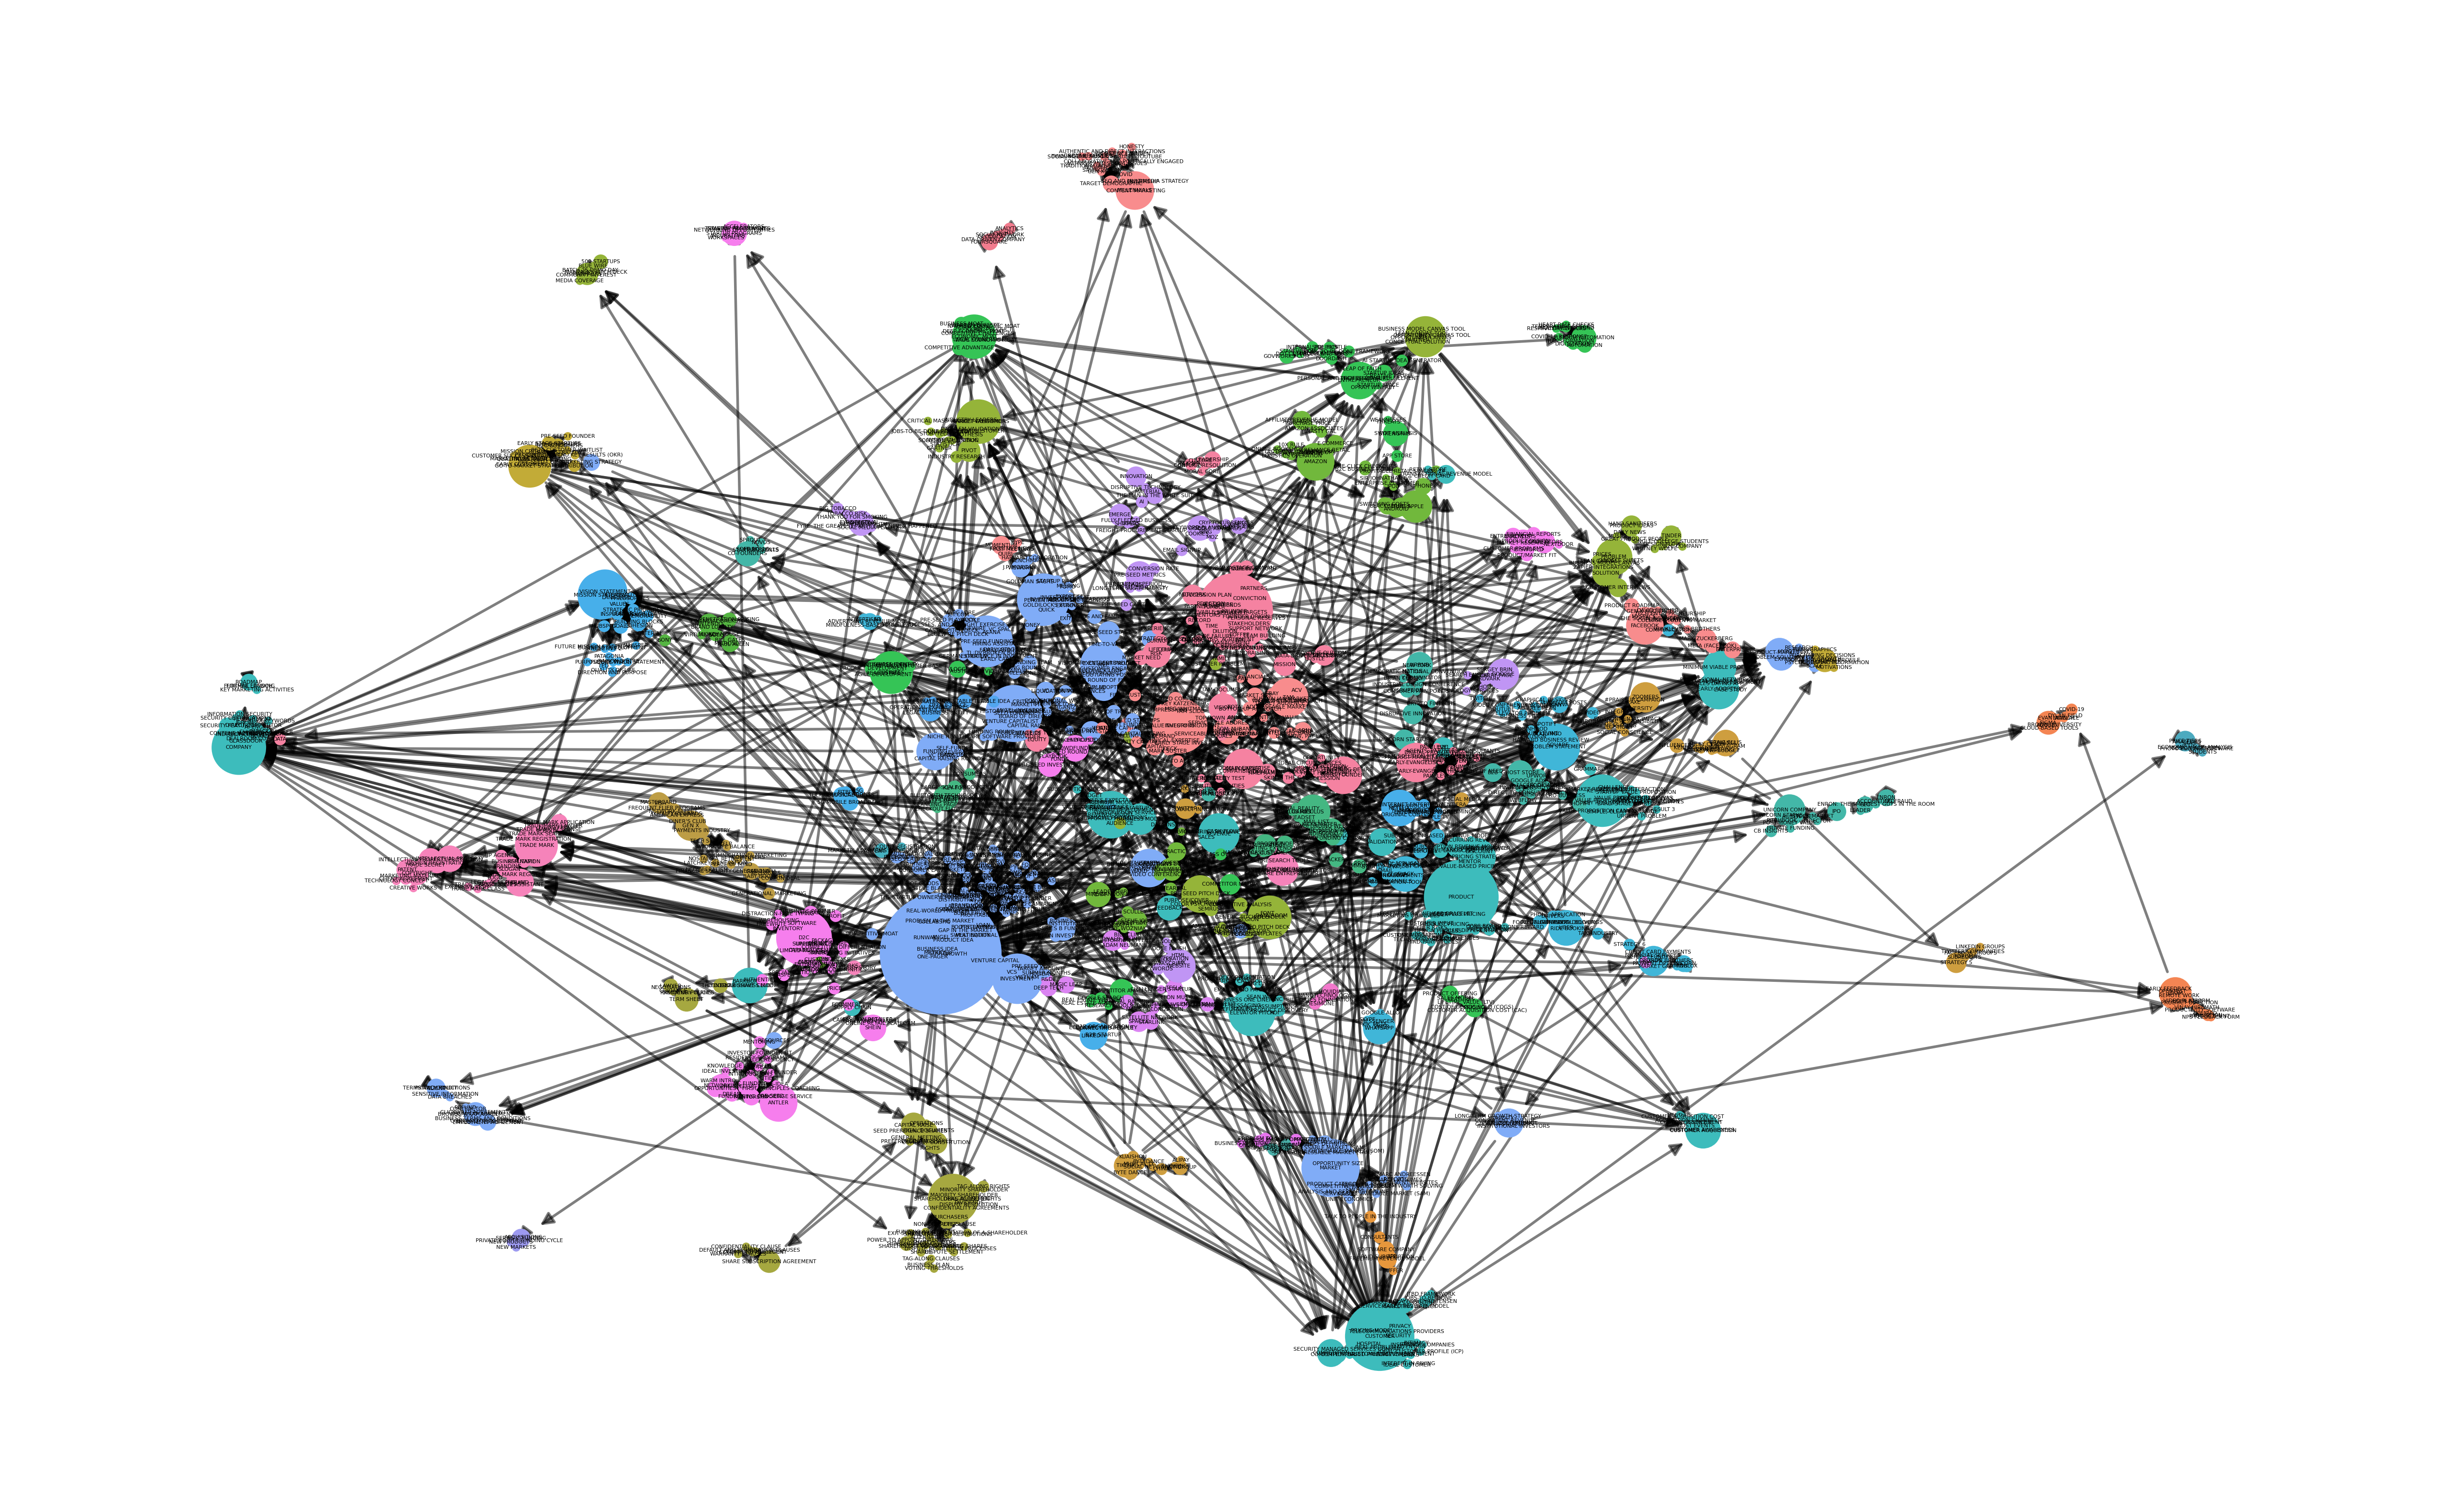

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graspologic as gc

# Load environment variables
from dotenv import load_dotenv
_ = load_dotenv()

# Define paths
FOLDER = "20240903-194043"
INPUT_DIR = f"../bin/output/{FOLDER}/artifacts" 
OUTPUT_DIR = f"../bin/output/{FOLDER}/artifacts" 

ENTITY_TABLE = "create_final_nodes"
RELATIONSHIP_TABLE = "create_final_relationships"

# Function to add color column to entities based on community
def add_color_column_to_entities(entity_df: pd.DataFrame, community_column: str = "community") -> pd.DataFrame:
    """
    Adds a 'color' column to the entity_df DataFrame based on unique community values.
    """
    # Ensure the community column exists in the dataframe
    if community_column not in entity_df.columns:
        raise ValueError(f"The specified community column '{community_column}' does not exist in the DataFrame.")
    # Get unique communities
    unique_communities = entity_df[community_column].unique()
    # Generate a color map for the unique communities
    color_map = gc.layouts.categorical_colors({str(community): community for community in unique_communities})
    # Map each community to its corresponding color
    entity_df['color'] = entity_df[community_column].map(lambda community: color_map[str(community)])
    return entity_df

# Convert entities to dictionaries for easier processing
def convert_entities_to_dicts(df):
    """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
    nodes_dict = {}
    df.drop(columns=["size"], inplace=True)
    
    # Make sure x and y are float and nor NaN
    df["x"] = df["x"].astype(float)
    df["y"] = df["y"].astype(float)
    df = df[~df["x"].isna()]
    df = df[~df["y"].isna()]
    
    for _, row in df.iterrows():
        node_id = row["title"]  # Use 'title' as the unique identifier
        if node_id not in nodes_dict:
            nodes_dict[node_id] = {
                "id": node_id,
                "properties": row.to_dict(),
            }
    return list(nodes_dict.values())

# Convert relationships to dictionaries
def convert_relationships_to_dicts(df):
    """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
    relationships = []
    for _, row in df.iterrows():
        relationships.append({
            "start": row["source"],
            "end": row["target"],
            "properties": row.to_dict(),
        })
    return relationships

# Load the dataframes from parquet files
entity_df = pd.read_parquet(f"{OUTPUT_DIR}/{ENTITY_TABLE}.parquet")
# Filter by "level" column to avoid "id" duplicates
entity_df = entity_df[entity_df["level"] == 0]
relationship_df = pd.read_parquet(f"{OUTPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
# Add color to each node based on the community
entity_df = add_color_column_to_entities(entity_df)
# Convert dataframes to required formats
nodes = convert_entities_to_dicts(entity_df)
edges = convert_relationships_to_dicts(relationship_df)

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and their attributes to the graph
for node in nodes:
    node_id = node["id"]
    properties = node["properties"]
    G.add_node(
        node_id, 
        pos=(properties["x"], properties["y"]), 
        size=properties["degree"], 
        node_color=properties["color"],
        label=properties["title"],  # Add the title as a label
        **properties
    )

# Check if all nodes referenced by edges have positions
missing_nodes = set()
filtered_edges = []

# Filter edges and add them to the graph
for edge in edges:
    source = edge["start"]
    target = edge["end"]
    
    # Ensure both source and target nodes exist in the graph
    if source not in G.nodes or target not in G.nodes:
        missing_nodes.update([source, target])
        continue
    
    edge_properties = edge["properties"]
    filtered_edges.append((source, target, edge_properties))

    G.add_edge(source, target, **edge_properties)

# Debugging: Print any missing nodes
if missing_nodes:
    print(f"Missing nodes detected: {missing_nodes}")
    print("Some edges will not be drawn due to missing node positions.")

# Prepare node position, size, and color for visualization
node_position_dict = {node["id"]: (node["properties"]["x"], node["properties"]["y"]) for node in nodes}
node_sizes = [node["properties"]["degree"] * 10 for node in nodes]  # Scale sizes for better visibility
node_colors = [node["properties"]["color"] for node in nodes]  # Get color from the node properties

assert len(node_position_dict) == len(node_sizes) == len(node_colors), f"Lengths of node attributes do not match ({len(node_position_dict)}, {len(node_sizes)}, {len(node_colors)})"

# Prepare node labels for visualization
node_labels = {node["id"]: node["properties"]["title"] for node in nodes}

# Plot the graph
plt.clf()
figure = plt.gcf()
ax = plt.gca()
ax.set_axis_off()
figure.set_size_inches(16.18, 10)
figure.set_dpi(400)

# Draw nodes with networkx
nx.draw_networkx_nodes(
    G,
    pos=node_position_dict,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=1.0,
    linewidths=0.01,
    node_shape="o",
    ax=ax,
)

# Draw edges only for nodes with defined positions
nx.draw_networkx_edges(G, pos=node_position_dict, edgelist=filtered_edges, ax=ax, alpha=0.5)
# Draw node labels
nx.draw_networkx_labels(G, pos=node_position_dict, labels=node_labels, ax=ax, font_size=2)
# Display the plot
plt.show()